In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Overview Data

In [5]:
df = pd.read_csv("twitter_sentiment.csv",header=None, index_col=0)
df.head()

,1,2,3
0,,,
2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2401,Borderlands,Positive,im coming on borderlands and i will murder you...
2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [6]:
df = df[[2,3]].reset_index(drop=True)
df = df.rename(columns={2:'sentiment',3:'text'})
df

,sentiment,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...
...,...,...
75677,Irrelevant,⭐️ Toronto is the arts and culture capital of ...
75678,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
75679,Positive,Today sucked so it’s time to drink wine n play...
75680,Positive,Bought a fraction of Microsoft today. Small wins.


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75682 entries, 0 to 75681
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  75682 non-null  object
 1   text       74996 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [8]:
df.isnull().sum()

sentiment      0
text         686
dtype: int64

In [9]:
df = df.dropna()
df.isnull().sum()

sentiment    0
text         0
dtype: int64

In [10]:
df = df[df['text'].apply(len)>5]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72883 entries, 0 to 75681
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  72883 non-null  object
 1   text       72883 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


In [11]:
df['sentiment'].value_counts()

sentiment
Negative      22020
Positive      20186
Neutral       17899
Irrelevant    12778
Name: count, dtype: int64

### Feature Extraction

In [12]:
import re
import os
import sys
import json

import pandas as pd
import numpy as np
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from bs4 import BeautifulSoup
import unicodedata
from textblob import TextBlob

from sklearn.feature_extraction.text import CountVectorizer
import spacy
nlp = spacy.load('en_core_web_sm')

In [13]:
def _get_wordcounts(x):
    length = len(str(x).split())
    return length

def _get_charcounts(x):
    s = x.split()
    x = ''.join(s)
    return len(x)

def _get_avg_wordlength(x):
    count = _get_charcounts(x)/_get_wordcounts(x)
    return count

def _get_stopwords_counts(x):
    l = len([t for t in x.split() if t in stopwords])
    return l

def _get_hashtag_counts(x):
    l = len([t for t in x.split() if t.startswith('#')])
    return l

def _get_mentions_counts(x):
    l = len([t for t in x.split() if t.startswith('@')])
    return l

def _get_digit_counts(x):
    digits = re.findall(r'[0-9,.]+', x)
    return len(digits)

def _get_uppercase_counts(x):
     return len([t for t in x.split() if t.isupper()])
    
def _get_emails(x):
    emails = re.findall(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+\b)', x)
    counts = len(emails)

    return counts, emails

def _get_urls(x):
    urls = re.findall(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', x)
    counts = len(urls)

    return counts, urls



In [14]:
def _get_basic_features(df):
    if type(df) == pd.core.frame.DataFrame:
        df['char_counts'] = df['text'].apply(lambda x: _get_charcounts(x))
        df['word_counts'] = df['text'].apply(lambda x: _get_wordcounts(x))
        df['avg_wordlength'] = df['text'].apply(lambda x: _get_avg_wordlength(x))
        df['stopwords_counts'] = df['text'].apply(lambda x: _get_stopwords_counts(x))
        df['hashtag_counts'] = df['text'].apply(lambda x: _get_hashtag_counts(x))
        df['mentions_counts'] = df['text'].apply(lambda x: _get_mentions_counts(x))
        df['digits_counts'] = df['text'].apply(lambda x: _get_digit_counts(x))
        df['uppercase_counts'] = df['text'].apply(lambda x: _get_uppercase_counts(x))
    else:
        print('ERROR: This function takes only Pandas DataFrame')
    
    return df

In [15]:
df = _get_basic_features(df)

In [16]:
df.head()

,sentiment,text,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,Positive,im getting on borderlands and i will murder yo...,43,11,3.909091,6,0,0,1,0
1,Positive,I am coming to the borders and I will kill you...,40,12,3.333333,6,0,0,1,2
2,Positive,im getting on borderlands and i will kill you ...,41,10,4.100000,5,0,0,1,0
3,Positive,im coming on borderlands and i will murder you...,42,10,4.200000,5,0,0,1,0
4,Positive,im getting on borderlands 2 and i will murder ...,46,12,3.833333,6,0,0,2,0


In [17]:
df.columns

Index(['sentiment', 'text', 'char_counts', 'word_counts', 'avg_wordlength',
       'stopwords_counts', 'hashtag_counts', 'mentions_counts',
       'digits_counts', 'uppercase_counts'],
      dtype='object')

In [18]:
df_num = df.select_dtypes('number')
df_num.columns

Index(['char_counts', 'word_counts', 'avg_wordlength', 'stopwords_counts',
       'hashtag_counts', 'mentions_counts', 'digits_counts',
       'uppercase_counts'],
      dtype='object')

C:\Users\Yogesh\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Yogesh\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Yogesh\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Yogesh\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

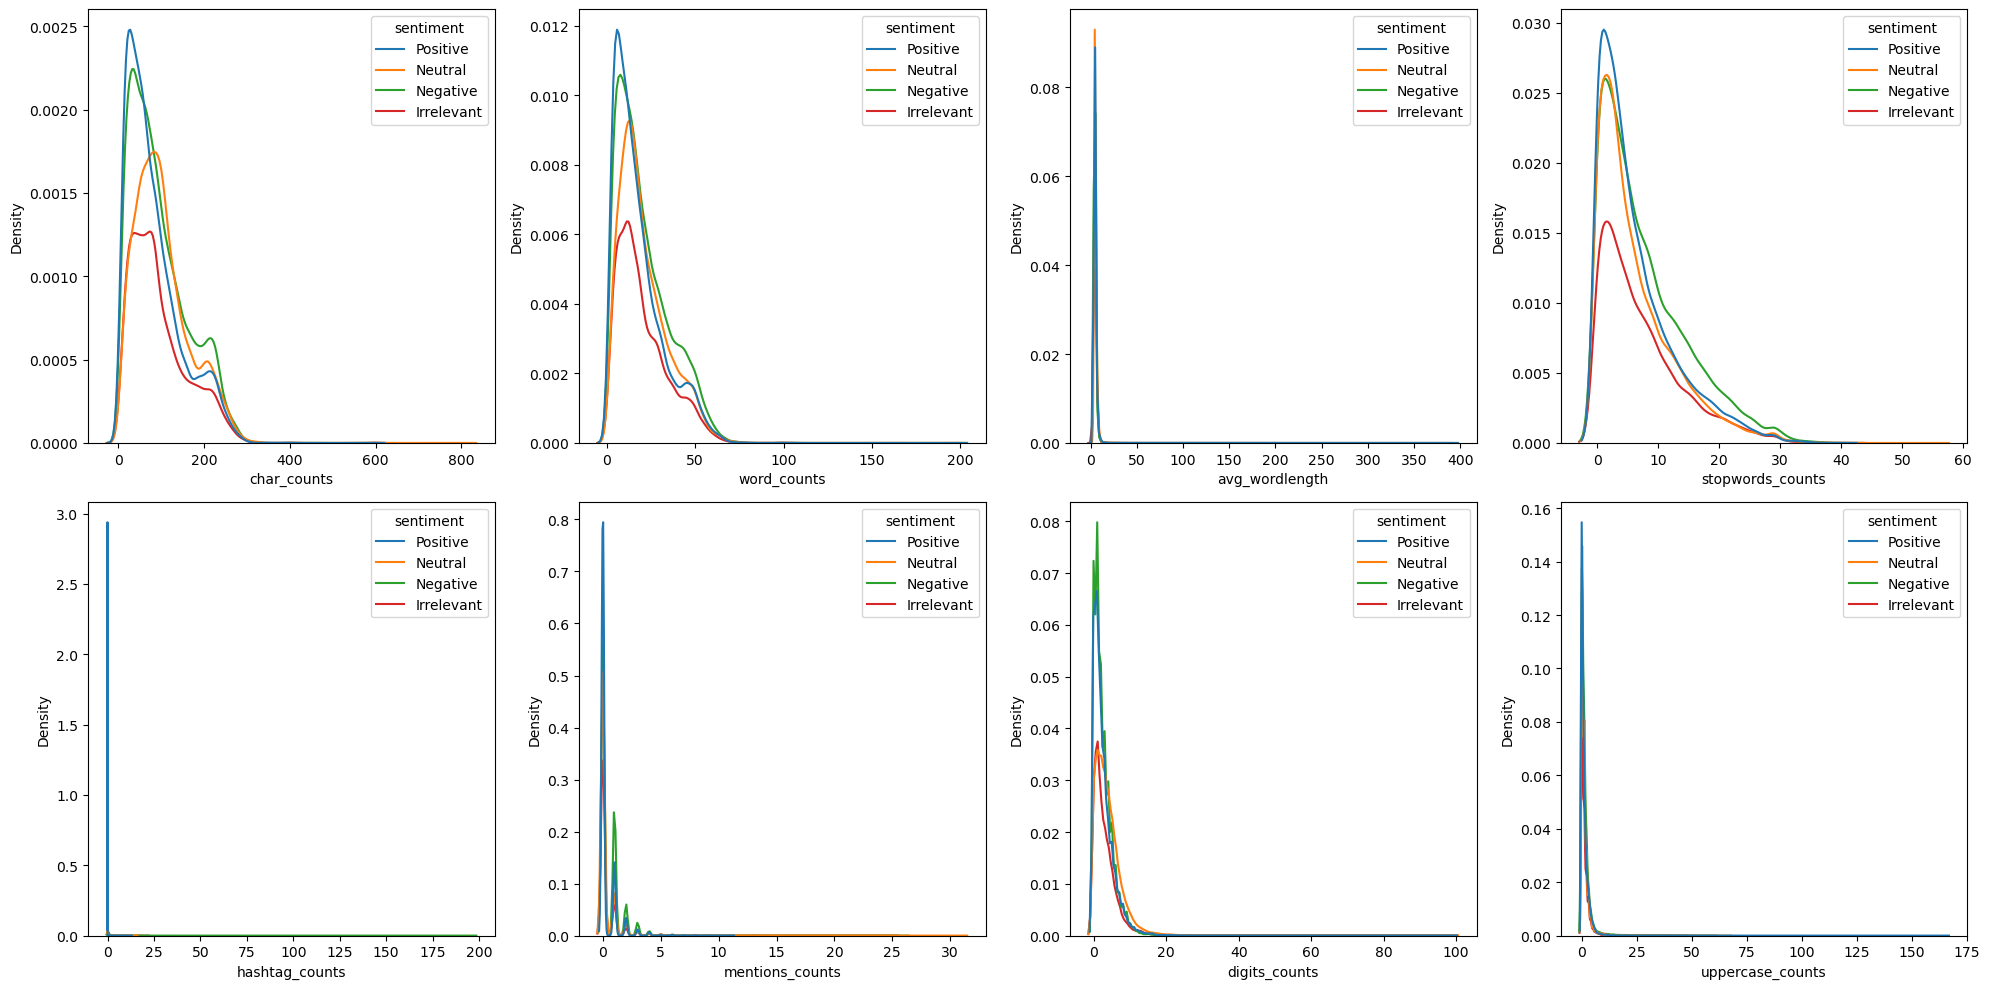

In [19]:
plt.figure(figsize=(20,10))

for i,col in enumerate(df_num):
    
    plt.subplot(2,4,i+1)
    
    sns.kdeplot(data=df,x=col,hue="sentiment")
    
plt.tight_layout()
plt.show()

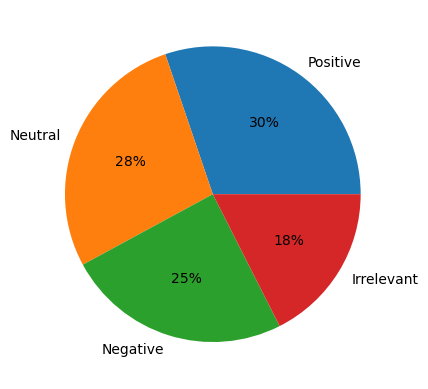

In [20]:
plt.pie(df['sentiment'].value_counts(),autopct='%1.0f%%',labels=df['sentiment'].unique().tolist())
plt.show()

### Data cleaning

In [21]:
def _remove_emails(x):
    return re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", x)


def _remove_urls(x):
    return re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , x)

def _remove_rt(x):
    return re.sub(r'\brt\b', '', x).strip()

def _remove_special_chars(x):
    x = re.sub(r'[^\w ]+', "", x)
    x = ' '.join(x.split())
    return x

def _remove_html_tags(x):
    return BeautifulSoup(x, 'lxml').get_text().strip()

def _remove_accented_chars(x):
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return x

def _remove_stopwords(x):
    return ' '.join([t for t in x.split() if t not in stopwords])

In [22]:
df['text'] = df['text'].apply(lambda x: x.lower())
df['text'] = df['text'].apply(lambda x: _remove_urls(x))
df['text'] = df['text'].apply(lambda x: _remove_html_tags(x))
df['text'] = df['text'].apply(lambda x: _remove_rt(x))
df['text'] = df['text'].apply(lambda x: _remove_special_chars(x))

C:\Users\Yogesh\AppData\Local\Temp\ipykernel_17472\3433755252.py:17: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(x, 'lxml').get_text().strip()


In [23]:
df['text']

0        im getting on borderlands and i will murder yo...
1        i am coming to the borders and i will kill you...
2        im getting on borderlands and i will kill you all
3        im coming on borderlands and i will murder you...
4        im getting on borderlands 2 and i will murder ...
                               ...                        
75677    toronto is the arts and culture capital of can...
75678    this is actually a good move tot bring more vi...
75679    today sucked so its time to drink wine n play ...
75680      bought a fraction of microsoft today small wins
75681    johnson johnson to stop selling talc baby powd...
Name: text, Length: 72883, dtype: object

### Train-Test Split data

In [24]:
X = df['text']

In [25]:
y = df['sentiment']

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Model building

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

In [69]:
clf = Pipeline([('tfidf',TfidfVectorizer()),
               ('model',RandomForestClassifier(n_jobs = -1,n_estimators=10))
               ])

In [70]:
clf.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('model', RandomForestClassifier(n_estimators=10, n_jobs=-1))])

In [71]:
y_pred = clf.predict(X_test)

In [72]:
y_pred[2]

'Negative'

In [73]:
X_test.iloc[2]

'2ksupport nba2k my boy whos new to the game and relies on me to teach him how to play was naughty when creating a ticket to figure out why he left a reply a few time claiming he was banned for boosting again he doesnt even know how to play other than what i show him 12'

In [74]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

  Irrelevant       0.89      0.80      0.84      2561
    Negative       0.85      0.93      0.89      4481
     Neutral       0.87      0.85      0.86      3553
    Positive       0.88      0.86      0.87      3982

    accuracy                           0.87     14577
   macro avg       0.87      0.86      0.87     14577
weighted avg       0.87      0.87      0.87     14577



In [75]:
clf.predict(['I am really glad to see you'])

array(['Positive'], dtype=object)

In [82]:
clf.predict(['You are going to loose not'])

array(['Negative'], dtype=object)

In [77]:
clf.predict(['I have neutral view on this'])

array(['Positive'], dtype=object)

### Saving Model 

In [78]:
import pickle 

creating three versions of models - 

1. twitter_sentiment.pkl - n_estimators(100)
2. twitter_sentiment_v1.pkl - n_estimators(50)
3. twitter_sentiment_v2.pkl - n_estimators(30)
4. twitter_sentiment_v3.pkl - n_estimators(20)
5. twitter_sentiment_v4.pkl - n_estimators(10)

In [79]:
pickle.dump(clf,open('twitter_sentiment_v4.pkl','wb'))

In [80]:
model = pickle.load(open('twitter_sentiment_v4.pkl','rb'))

In [81]:
model.predict(['I am good'])

array(['Irrelevant'], dtype=object)

#### classification report comparision